In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

from Models import tcn
from train.Dataset import CustomDataset
from train.TrainHelpers import train_model, plot_loss_graph, encode_data, train_svm
from train.TestHelpers import test_model, calculate_accuracy

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [2]:
### PARAMETERS ###
dataset_ver = '3w05s_Larm'
n_input = 9
n_hidden = 360
seed = 345

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

x_train = np.load(f'Generated_Datasets/train_data_{dataset_ver}.npy')
x_val = np.load(f'Generated_Datasets/val_data_{dataset_ver}.npy')
x_test = np.load(f'Generated_Datasets/test_data_{dataset_ver}.npy')

y_train = np.load(f'Generated_Datasets/train_labels_{dataset_ver}.npy')
y_val = np.load(f'Generated_Datasets/val_labels_{dataset_ver}.npy')
y_test = np.load(f'Generated_Datasets/test_labels_{dataset_ver}.npy')

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)

(11578, 60, 9)
(11578,)
(1654, 60, 9)


(11578, 60, 9) (3308, 60, 9) (1654, 60, 9)


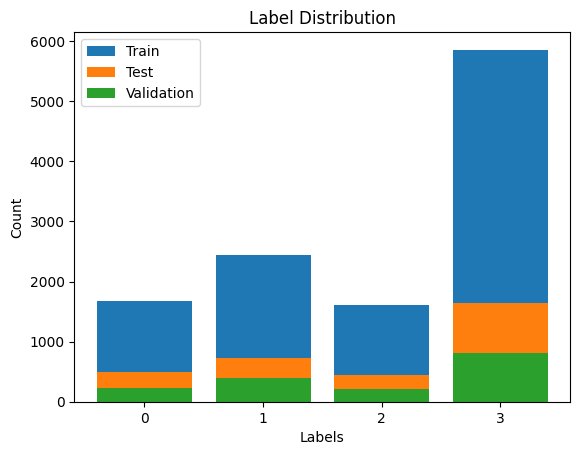

In [4]:
# Check Dataset
print(x_train.shape, x_test.shape, x_val.shape)
unique_labels_train, label_counts_train = np.unique(y_train, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.legend()
plt.show()

In [5]:
### Declare Dataloaders
train_dataset = CustomDataset("train", dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataset = CustomDataset("val", dataset_ver)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)
test_dataset = CustomDataset("test", dataset_ver)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [6]:
for X, y in train_dataloader:
    print(f'{X.shape=}')
    print(f'{y.shape=}')
    break   

X.shape=torch.Size([1, 60, 9])
y.shape=torch.Size([1])


In [7]:
class tcn_classifier(nn.Module):
    def __init__(self, num_inputs, tcn_channels, causal, skip):
        super(tcn_classifier, self).__init__()

        # if tcn_channels[-1] != mlp_layer_dims[0]:
        #     raise ValueError("Output of TCN must match input to MLP!")

        self.tcn = tcn.TCN(num_inputs=num_inputs,
                            num_channels=tcn_channels,
                            causal=causal,
                            input_shape='NLC',
                            use_skip_connections=skip)
        
        # self.mlp = nn.Sequential()

        # for i in range(len(mlp_layer_dims)-1):
        #     self.mlp.add_module(f'fc{i+1}', nn.Linear(mlp_layer_dims[i], mlp_layer_dims[i+1]))


    def forward(self, x):
        x = self.tcn(x)
        # x = self.mlp(x)
        # print(x.shape)
        return x[0][-1]

In [8]:
def train_TCN(model, learning_rate, num_epochs, tag):
    optimizer = optim.Adam(model.parameters(),
                            lr=learning_rate,
                            betas=(0.9, 0.999),
                            eps=1e-8)

    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Starting Epoch {epoch+1}...')
        model.train()

        train_preds = []
        train_labels = []

        for train_X, train_y in tqdm(train_dataloader):
            optimizer.zero_grad()
            
            train_output = model(train_X)

            train_loss = criterion(train_output, train_y[0].type(torch.LongTensor))
            train_loss.backward()
            optimizer.step()

            train_preds.append(torch.argmax(train_output))
            train_labels.append(train_y)
        
        train_losses.append(train_loss.item())
        print(f'Train Loss = {train_losses[-1]}')

        train_acc = accuracy_score(train_labels, train_preds)
        print(f'Train Acc = {train_acc}')

        model.eval()

        val_preds = []
        val_labels = []

        for val_X, val_y in tqdm(val_dataloader):
            val_output = model(val_X)

            val_preds.append(torch.argmax(val_output))
            val_labels.append(val_y)

        val_losses.append(criterion(val_output, val_y[0].type(torch.LongTensor)))
        print(f'Val Loss = {val_losses[-1]}')

        val_acc = accuracy_score(val_labels, val_preds)
        print(f'Val Acc = {val_acc}')

    torch.save(deepcopy(model.state_dict()), f'ML_Models/TCN_{tag}.pt')

    return train_losses, val_losses


In [9]:
tcn_model_1 = tcn_classifier(9, [128, 64, 32, 16, 4], True, False)
print(tcn_model_1)
train_losses, val_losses = train_TCN(tcn_model_1, 1e-3, 5, 'Causal_128-64-32-16-4')

tcn_classifier(
  (tcn): TCN(
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): ParametrizedCausalConv1d(
          9, 128, kernel_size=(4,), stride=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (conv2): ParametrizedCausalConv1d(
          128, 128, kernel_size=(4,), stride=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (downsample): Conv1d(9, 128, kernel_size=(1,), stride=(1,))
      )
      (1): TemporalBlock(
        (conv1): ParametrizedCausalConv1d(
          128, 64, kernel_size=(4,), stride=(1,), dilation=(2,)
          (parametriz

  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.333073228597641
Train Acc = 0.7598894455000864


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 0.39692041277885437
Val Acc = 0.8724304715840387
Starting Epoch 2...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.002203538315370679
Train Acc = 0.8570564864397996


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 0.016455646604299545
Val Acc = 0.898428053204353
Starting Epoch 3...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.061679501086473465
Train Acc = 0.8907410606322336


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 0.06786178052425385
Val Acc = 0.9087061668681983
Starting Epoch 4...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.28527432680130005
Train Acc = 0.9115564000690966


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 4.851700214203447e-05
Val Acc = 0.9244256348246674
Starting Epoch 5...


  0%|          | 0/11578 [00:00<?, ?it/s]

Train Loss = 0.000553335587028414
Train Acc = 0.9243392641216099


  0%|          | 0/1654 [00:00<?, ?it/s]

Val Loss = 1.8358061424805783e-05
Val Acc = 0.9407496977025392


In [11]:
tcn_model_2 = tcn_classifier(9, [128, 64, 32, 16, 4], False, True)
print(tcn_model_2)
train_losses, val_losses = train_TCN(tcn_model_2, 1e-3, 5, '128-64-32-16-8-4')

TypeError: tcn_classifier.__init__() takes 3 positional arguments but 5 were given